In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0,1,2,3
%env CUDA_LAUNCH_BLOCKING=1

%load_ext autoreload 
%autoreload 2
%matplotlib inline

import os
import sys
import glob
import time
import io
import pickle

try:
    os.chdir('./MantraNet')
except:
    pass

import matplotlib.pyplot as plt
import numpy as np
import cv2
import skimage
import scipy
import pandas as pd

import torch

from PIL import Image
from sklearn.metrics import confusion_matrix

from MantraNet.mantranet import pre_trained_model

ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu") #to change if you have a GPU with at least 12Go RAM (it will save you a lot of time !)

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0,1,2,3
env: CUDA_LAUNCH_BLOCKING=1


/home/y/yuanbo/packages/miniconda3/envs/mantra/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.path.append('/home/y/yuanbo/fyp/estimate_jpeg')
sys.path.append('/home/y/yuanbo/fyp/estimate_jpeg/utils')

from utils import *

In [3]:
stime = time.time()
model = pre_trained_model(weight_path='./MantraNetv4.pt',device=device)
print(f"Took {round(time.time() - stime, 2)}s to load model.")

Took 14.91s to load model.


In [4]:
casia_data_paths = pd.read_csv('casia_filtered_tif_paths.csv')
print(len(casia_data_paths))
casia_data_paths.head()

644


,tampered,ground_truth,source,target
0,Tp_D_CND_M_N_ani00018_sec00096_00138.tif,Tp_D_CND_M_N_ani00018_sec00096_00138_gt.png,Au_ani_00018.jpg,Au_sec_00096.jpg
1,Tp_D_CND_M_N_art00076_art00077_10289.tif,Tp_D_CND_M_N_art00076_art00077_10289_gt.png,Au_art_00076.jpg,Au_art_00077.jpg
2,Tp_D_CND_M_N_art00077_art00076_10290.tif,Tp_D_CND_M_N_art00077_art00076_10290_gt.png,Au_art_00077.jpg,Au_art_00076.jpg
3,Tp_D_CND_S_N_ani00073_ani00068_00193.tif,Tp_D_CND_S_N_ani00073_ani00068_00193_gt.png,Au_ani_00073.jpg,Au_ani_00068.jpg
4,Tp_D_CND_S_N_ind00078_ind00077_00476.tif,Tp_D_CND_S_N_ind00078_ind00077_00476_gt.png,Au_ind_00078.jpg,Au_ind_00077.jpg


In [5]:
casia_dir = '/home/y/yuanbo/datasets/CASIA2.0_revised'
tampered_dir = os.path.join(casia_dir, 'Tp')
ground_truth_dir = os.path.join(casia_dir, 'groundtruth')
authentic_dir = os.path.join(casia_dir, 'Au')
work_dir = '/home/y/yuanbo/fyp/mantra-net/'

## Define pixel-level F1 score

According to paper "Image splicing localization using a multi-task fully convolutional network (MFCN)", the pixel level F1 score is defined as follows:
$$
F_1(M_\text{out}, M_{gt}) = \frac{2TP}{2TP + FN + FP}
$$
where:
- $M_\text{out}$ represents the binary system output mask (after thresholding)
- $M_{gt}$ represents the ground truth mask

In [6]:
pred = np.array([
    [0, 0, 0],
    [1, 1, 1],
    [0, 1, 1],
])
gt = np.array([
    [0, 1, 1],
    [1, 0, 1],
    [0, 1, 1],
])
# TP = 4
# FP = 1
# FN = 2
# TN = 2

In [7]:
confusion_matrix(gt.reshape(-1), pred.reshape(-1)).ravel()

array([2, 1, 2, 4])

In [8]:
def pixel_f1_score(pred, gt):
    tn, fp, fn, tp = confusion_matrix(gt, pred).ravel()
    f1_score = (2 * tp) / ((2 * tp) + fn + fp)
    return f1_score

In [9]:
pixel_f1_score(pred.reshape(-1), gt.reshape(-1))

0.7272727272727273

## Define helper functions

In [10]:
def get_splice_from_mask(img, mask):
    return mask[..., None] * img

def get_splice_from_mask_white(img, mask):
    """Change background of splice to white"""
    splice = get_splice_from_mask(img, mask)
    return splice + (1 - mask)[..., None] * 255 

def predict(model, tampered_image, device=device):
    """Returns the predicted probability map of tampered_image."""
    model.to(device)
    model.eval()
    
    im = torch.Tensor(tampered_image)
    im = im.unsqueeze(0)
    im = im.transpose(2, 3).transpose(1, 2) # B*H*W*C -> B*C*H*W
    im = im.to(device)

    with torch.no_grad():
        final_output = model(im)  # B*C*H*W = 1*1*H*W, assuming input of 1 image

    return final_output.squeeze().cpu().detach().numpy()

def get_regions_above_threshold(probs, image, threshold=0.5):
    """Returns an image of regions where probability of it being tampered > threshold,
    with white background."""
    return get_splice_from_mask_white(image, (probs > threshold).astype(int))

    
def plot_images(images):
    for i in range(len(images)):
        nrow, ncol = 1, 4
        plt.figure(figsize=(7*ncol,5*nrow))

        plt.subplot(nrow,ncol,1)
        plt.imshow(images[i]["clean"])
        plt.title('clean image')
        
        plt.subplot(nrow,ncol,2)
        plt.imshow(images[i]["tampered"])
        plt.title('Tampered')

        plt.subplot(nrow,ncol,3)
        plt.imshow(images[i]["ground_truth"])
        plt.title('Ground truth')

        plt.subplot(nrow,ncol,4)
        plt.imshow(images[i]["copy_source"])
        plt.title('Copy source')

## Jpeg compression attack

The attack is simple, just compress the tampered image in increasing levels of compression strengths (or decreasing levels of `compression_quality`), and evaluate MantraNet's performance on the compressed images.

In [11]:
compression_quality = [90, 80, 70, 60, 50]
threshold = 0.1

In [14]:
results = {
    "original": [],
    "90": [],
    "80": [],
    "70": [],
    "60": [],
    "50": [],
#     "gt_path": [],
}

start = time.time()
for i, row in casia_data_paths.iterrows():
    tp_path = os.path.join(tampered_dir, row['tampered'])
    gt_path = os.path.join(ground_truth_dir, row['ground_truth'])
    
    tp_img = np.array(Image.open(tp_path))
    gt_mask = (np.array(Image.open(gt_path).convert('L')) > 0).astype(int)

    # original clean predictions by mantra net
    probs = predict(model, tp_img)
    results['original'].append(probs)
    
    # calculate f1 score based on baseline threshold of 0.5
    pred = (probs > threshold).astype(int)
    f1_original = pixel_f1_score(pred.reshape(-1), gt_mask.reshape(-1))

    # Compress images and show MantraNet predictions
    comp_str = ""
    for q in compression_quality:
        buffer = io.BytesIO()
        Image.open(tp_path).save(buffer, format='jpeg', quality=q, subsampling=0)
        compressed = np.array(Image.open(buffer))
        
        probs_compressed = predict(model, compressed)
        results[str(q)].append(probs_compressed)

        pred_compressed = (probs_compressed > threshold).astype(int)
        f1_compressed = pixel_f1_score(pred_compressed.reshape(-1), gt_mask.reshape(-1))
        comp_str += f", {q}: {round(f1_compressed, 2)}"
        
        
    etime = time.time()
    time_per_iter = round((etime - start)/(i+1), 2)
    time_left = time_per_iter * (len(casia_data_paths) - i - 1) / 60
    print(f"[{i+1}/{len(casia_data_paths)}] - {time_per_iter}s per img, {round(time_left, 2)} mins to go - ori: {round(f1_original, 2)}{comp_str}")

[1/644] - 3.04s per img, 32.58 mins to go - ori: 0.36, 90: 0.1, 80: 0.11, 70: 0.02, 60: 0.0, 50: 0.01
[2/644] - 3.01s per img, 32.21 mins to go - ori: 0.63, 90: 0.41, 80: 0.39, 70: 0.37, 60: 0.49, 50: 0.4
[3/644] - 3.33s per img, 35.58 mins to go - ori: 0.59, 90: 0.62, 80: 0.6, 70: 0.63, 60: 0.57, 50: 0.49
[4/644] - 3.43s per img, 36.59 mins to go - ori: 0.45, 90: 0.05, 80: 0.01, 70: 0.12, 60: 0.17, 50: 0.09
[5/644] - 3.48s per img, 37.06 mins to go - ori: 0.27, 90: 0.03, 80: 0.33, 70: 0.07, 60: 0.14, 50: 0.19
[6/644] - 3.69s per img, 39.24 mins to go - ori: 0.69, 90: 0.54, 80: 0.6, 70: 0.43, 60: 0.37, 50: 0.19
[7/644] - 3.49s per img, 37.05 mins to go - ori: 0.0, 90: 0.0, 80: 0.02, 70: 0.0, 60: 0.03, 50: 0.07
[8/644] - 3.35s per img, 35.51 mins to go - ori: 0.08, 90: 0.0, 80: 0.02, 70: 0.0, 60: 0.0, 50: 0.14
[9/644] - 3.32s per img, 35.14 mins to go - ori: 0.11, 90: 0.0, 80: 0.0, 70: 0.1, 60: 0.0, 50: 0.0
[10/644] - 3.37s per img, 35.61 mins to go - ori: 0.45, 90: 0.08, 80: 0.14, 70: 

[80/644] - 3.69s per img, 34.69 mins to go - ori: 0.26, 90: 0.18, 80: 0.21, 70: 0.22, 60: 0.18, 50: 0.02
[81/644] - 3.69s per img, 34.62 mins to go - ori: 0.19, 90: 0.18, 80: 0.19, 70: 0.22, 60: 0.17, 50: 0.12
[82/644] - 3.68s per img, 34.47 mins to go - ori: 0.39, 90: 0.22, 80: 0.11, 70: 0.1, 60: 0.12, 50: 0.07
[83/644] - 3.69s per img, 34.5 mins to go - ori: 0.49, 90: 0.13, 80: 0.25, 70: 0.09, 60: 0.09, 50: 0.13
[84/644] - 3.68s per img, 34.35 mins to go - ori: 0.15, 90: 0.07, 80: 0.14, 70: 0.16, 60: 0.14, 50: 0.12
[85/644] - 3.67s per img, 34.19 mins to go - ori: 0.71, 90: 0.29, 80: 0.38, 70: 0.42, 60: 0.3, 50: 0.31
[86/644] - 3.67s per img, 34.13 mins to go - ori: 0.6, 90: 0.48, 80: 0.36, 70: 0.53, 60: 0.27, 50: 0.26
[87/644] - 3.67s per img, 34.07 mins to go - ori: 0.41, 90: 0.14, 80: 0.07, 70: 0.15, 60: 0.17, 50: 0.03
[88/644] - 3.66s per img, 33.92 mins to go - ori: 0.23, 90: 0.16, 80: 0.02, 70: 0.03, 60: 0.0, 50: 0.0
[89/644] - 3.78s per img, 34.97 mins to go - ori: 0.41, 90: 0

[159/644] - 4.07s per img, 32.9 mins to go - ori: 0.04, 90: 0.02, 80: 0.04, 70: 0.09, 60: 0.11, 50: 0.11
[160/644] - 4.07s per img, 32.83 mins to go - ori: 0.3, 90: 0.26, 80: 0.2, 70: 0.17, 60: 0.15, 50: 0.13
[161/644] - 4.06s per img, 32.68 mins to go - ori: 0.37, 90: 0.18, 80: 0.12, 70: 0.18, 60: 0.17, 50: 0.27
[162/644] - 4.06s per img, 32.62 mins to go - ori: 0.43, 90: 0.29, 80: 0.41, 70: 0.45, 60: 0.29, 50: 0.34
[163/644] - 4.06s per img, 32.55 mins to go - ori: 0.26, 90: 0.08, 80: 0.16, 70: 0.22, 60: 0.26, 50: 0.38
[164/644] - 4.06s per img, 32.48 mins to go - ori: 0.53, 90: 0.12, 80: 0.15, 70: 0.18, 60: 0.23, 50: 0.26
[165/644] - 4.07s per img, 32.49 mins to go - ori: 0.15, 90: 0.1, 80: 0.1, 70: 0.13, 60: 0.23, 50: 0.28
[166/644] - 4.07s per img, 32.42 mins to go - ori: 0.12, 90: 0.0, 80: 0.06, 70: 0.02, 60: 0.05, 50: 0.0
[167/644] - 4.09s per img, 32.52 mins to go - ori: 0.45, 90: 0.25, 80: 0.23, 70: 0.23, 60: 0.34, 50: 0.45
[168/644] - 4.11s per img, 32.61 mins to go - ori: 0.

[237/644] - 4.23s per img, 28.69 mins to go - ori: 0.05, 90: 0.01, 80: 0.05, 70: 0.06, 60: 0.15, 50: 0.12
[238/644] - 4.23s per img, 28.62 mins to go - ori: 0.31, 90: 0.05, 80: 0.12, 70: 0.03, 60: 0.04, 50: 0.06
[239/644] - 4.22s per img, 28.48 mins to go - ori: 0.39, 90: 0.21, 80: 0.38, 70: 0.16, 60: 0.14, 50: 0.1
[240/644] - 4.22s per img, 28.41 mins to go - ori: 0.08, 90: 0.04, 80: 0.04, 70: 0.04, 60: 0.13, 50: 0.17
[241/644] - 4.22s per img, 28.34 mins to go - ori: 0.3, 90: 0.12, 80: 0.21, 70: 0.08, 60: 0.13, 50: 0.21
[242/644] - 4.22s per img, 28.27 mins to go - ori: 0.23, 90: 0.21, 80: 0.14, 70: 0.08, 60: 0.0, 50: 0.03
[243/644] - 4.21s per img, 28.14 mins to go - ori: 0.18, 90: 0.13, 80: 0.3, 70: 0.07, 60: 0.07, 50: 0.0
[244/644] - 4.21s per img, 28.07 mins to go - ori: 0.28, 90: 0.08, 80: 0.28, 70: 0.35, 60: 0.05, 50: 0.09
[245/644] - 4.22s per img, 28.06 mins to go - ori: 0.34, 90: 0.15, 80: 0.07, 70: 0.07, 60: 0.08, 50: 0.01
[246/644] - 4.22s per img, 27.99 mins to go - ori: 

[315/644] - 4.76s per img, 26.1 mins to go - ori: 0.12, 90: 0.14, 80: 0.1, 70: 0.13, 60: 0.16, 50: 0.12
[316/644] - 4.76s per img, 26.02 mins to go - ori: 0.37, 90: 0.14, 80: 0.16, 70: 0.21, 60: 0.21, 50: 0.12
[317/644] - 4.76s per img, 25.94 mins to go - ori: 0.76, 90: 0.56, 80: 0.6, 70: 0.65, 60: 0.75, 50: 0.22
[318/644] - 4.75s per img, 25.81 mins to go - ori: 0.28, 90: 0.04, 80: 0.04, 70: 0.11, 60: 0.03, 50: 0.01
[319/644] - 4.75s per img, 25.73 mins to go - ori: 0.59, 90: 0.14, 80: 0.15, 70: 0.27, 60: 0.0, 50: 0.0
[320/644] - 4.75s per img, 25.65 mins to go - ori: 0.53, 90: 0.5, 80: 0.27, 70: 0.31, 60: 0.3, 50: 0.25
[321/644] - 4.74s per img, 25.52 mins to go - ori: 0.4, 90: 0.28, 80: 0.28, 70: 0.28, 60: 0.18, 50: 0.07
[322/644] - 4.74s per img, 25.44 mins to go - ori: 0.15, 90: 0.13, 80: 0.13, 70: 0.16, 60: 0.15, 50: 0.0
[323/644] - 4.75s per img, 25.41 mins to go - ori: 0.24, 90: 0.04, 80: 0.04, 70: 0.05, 60: 0.03, 50: 0.03
[324/644] - 4.75s per img, 25.33 mins to go - ori: 0.43

[394/644] - 4.64s per img, 19.33 mins to go - ori: 0.48, 90: 0.39, 80: 0.43, 70: 0.52, 60: 0.49, 50: 0.42
[395/644] - 4.63s per img, 19.21 mins to go - ori: 0.54, 90: 0.26, 80: 0.07, 70: 0.3, 60: 0.25, 50: 0.18
[396/644] - 4.63s per img, 19.14 mins to go - ori: 0.31, 90: 0.13, 80: 0.17, 70: 0.33, 60: 0.27, 50: 0.03
[397/644] - 4.63s per img, 19.06 mins to go - ori: 0.25, 90: 0.06, 80: 0.13, 70: 0.14, 60: 0.08, 50: 0.09
[398/644] - 4.63s per img, 18.98 mins to go - ori: 0.45, 90: 0.36, 80: 0.36, 70: 0.48, 60: 0.42, 50: 0.08
[399/644] - 4.62s per img, 18.87 mins to go - ori: 0.12, 90: 0.05, 80: 0.04, 70: 0.09, 60: 0.09, 50: 0.04
[400/644] - 4.62s per img, 18.79 mins to go - ori: 0.2, 90: 0.15, 80: 0.06, 70: 0.19, 60: 0.24, 50: 0.12
[401/644] - 4.62s per img, 18.71 mins to go - ori: 0.2, 90: 0.01, 80: 0.02, 70: 0.01, 60: 0.03, 50: 0.02
[402/644] - 4.62s per img, 18.63 mins to go - ori: 0.19, 90: 0.07, 80: 0.02, 70: 0.06, 60: 0.07, 50: 0.03
[403/644] - 4.61s per img, 18.52 mins to go - ori

[472/644] - 4.56s per img, 13.07 mins to go - ori: 0.32, 90: 0.25, 80: 0.31, 70: 0.31, 60: 0.31, 50: 0.3
[473/644] - 4.56s per img, 13.0 mins to go - ori: 0.24, 90: 0.07, 80: 0.04, 70: 0.24, 60: 0.2, 50: 0.24
[474/644] - 4.56s per img, 12.92 mins to go - ori: 0.41, 90: 0.35, 80: 0.43, 70: 0.47, 60: 0.45, 50: 0.42
[475/644] - 4.56s per img, 12.84 mins to go - ori: 0.66, 90: 0.26, 80: 0.35, 70: 0.25, 60: 0.17, 50: 0.18
[476/644] - 4.56s per img, 12.77 mins to go - ori: 0.32, 90: 0.18, 80: 0.16, 70: 0.15, 60: 0.2, 50: 0.18
[477/644] - 4.56s per img, 12.69 mins to go - ori: 0.64, 90: 0.48, 80: 0.33, 70: 0.4, 60: 0.25, 50: 0.24
[478/644] - 4.56s per img, 12.62 mins to go - ori: 0.25, 90: 0.15, 80: 0.36, 70: 0.31, 60: 0.38, 50: 0.38
[479/644] - 4.55s per img, 12.51 mins to go - ori: 0.08, 90: 0.07, 80: 0.01, 70: 0.04, 60: 0.07, 50: 0.06
[480/644] - 4.55s per img, 12.44 mins to go - ori: 0.39, 90: 0.26, 80: 0.29, 70: 0.33, 60: 0.19, 50: 0.28
[481/644] - 4.55s per img, 12.36 mins to go - ori: 

[569/644] - 4.53s per img, 5.66 mins to go - ori: 0.21, 90: 0.06, 80: 0.02, 70: 0.03, 60: 0.09, 50: 0.1
[570/644] - 4.53s per img, 5.59 mins to go - ori: 0.58, 90: 0.28, 80: 0.2, 70: 0.24, 60: 0.25, 50: 0.22
[571/644] - 4.53s per img, 5.51 mins to go - ori: 0.52, 90: 0.3, 80: 0.41, 70: 0.26, 60: 0.18, 50: 0.07
[572/644] - 4.53s per img, 5.44 mins to go - ori: 0.88, 90: 0.73, 80: 0.65, 70: 0.73, 60: 0.22, 50: 0.31
[573/644] - 4.52s per img, 5.35 mins to go - ori: 0.27, 90: 0.03, 80: 0.25, 70: 0.29, 60: 0.01, 50: 0.03
[574/644] - 4.52s per img, 5.27 mins to go - ori: 0.66, 90: 0.41, 80: 0.31, 70: 0.51, 60: 0.22, 50: 0.15
[575/644] - 4.52s per img, 5.2 mins to go - ori: 0.21, 90: 0.16, 80: 0.19, 70: 0.26, 60: 0.14, 50: 0.14
[576/644] - 4.52s per img, 5.12 mins to go - ori: 0.44, 90: 0.05, 80: 0.0, 70: 0.11, 60: 0.12, 50: 0.01
[577/644] - 4.52s per img, 5.05 mins to go - ori: 0.71, 90: 0.44, 80: 0.23, 70: 0.12, 60: 0.4, 50: 0.35
[578/644] - 4.52s per img, 4.97 mins to go - ori: 0.65, 90: 0

In [16]:
import pickle
with open('casia2.0_mantra_results.pkl', 'wb') as handle:
    pickle.dump(results, handle)

MemoryError: 

In [40]:
thres = 0.21

mean_f1 = {
    "original": 0,
    "90": 0,
    "80": 0,
    "70": 0,
    "60": 0,
    "50": 0,
}

for i, row in casia_data_paths.iterrows():
    stime = time.time()
    gt_path = os.path.join(ground_truth_dir, row['ground_truth'])
    gt_mask = (np.array(Image.open(gt_path).convert('L')) > 0).astype(int)

    for k in results.keys():
        probs = results[k][i]
        pred = (probs > thres).astype(int)
        f1 = pixel_f1_score(pred.reshape(-1), gt_mask.reshape(-1))
        mean_f1[k] += f1
    
    etime = time.time()
    print(f"Iter {i+1}/{644}: {round(etime - stime, 2)}s taken")


for k in mean_f1.keys():
    mean_f1[k] /= 644

Iter 1/644: 0.48s taken
Iter 2/644: 0.26s taken
Iter 3/644: 0.24s taken
Iter 4/644: 0.31s taken
Iter 5/644: 0.32s taken
Iter 6/644: 0.31s taken
Iter 7/644: 0.13s taken
Iter 8/644: 0.15s taken
Iter 9/644: 0.32s taken
Iter 10/644: 0.34s taken
Iter 11/644: 0.32s taken
Iter 12/644: 0.24s taken
Iter 13/644: 0.58s taken
Iter 14/644: 0.43s taken
Iter 15/644: 0.3s taken
Iter 16/644: 0.38s taken
Iter 17/644: 0.31s taken
Iter 18/644: 0.65s taken
Iter 19/644: 0.33s taken
Iter 20/644: 0.31s taken
Iter 21/644: 0.14s taken
Iter 22/644: 0.32s taken
Iter 23/644: 0.27s taken
Iter 24/644: 0.4s taken
Iter 25/644: 0.36s taken
Iter 26/644: 0.38s taken
Iter 27/644: 0.34s taken
Iter 28/644: 0.35s taken
Iter 29/644: 0.36s taken
Iter 30/644: 0.14s taken
Iter 31/644: 0.16s taken
Iter 32/644: 0.31s taken
Iter 33/644: 0.28s taken
Iter 34/644: 0.33s taken
Iter 35/644: 0.19s taken
Iter 36/644: 0.53s taken
Iter 37/644: 0.47s taken
Iter 38/644: 0.48s taken
Iter 39/644: 0.44s taken
Iter 40/644: 0.47s taken
Iter 41/644

Iter 322/644: 0.24s taken
Iter 323/644: 0.68s taken
Iter 324/644: 0.21s taken
Iter 325/644: 0.27s taken
Iter 326/644: 0.32s taken
Iter 327/644: 0.27s taken
Iter 328/644: 0.21s taken
Iter 329/644: 0.28s taken
Iter 330/644: 0.32s taken
Iter 331/644: 0.19s taken
Iter 332/644: 0.36s taken
Iter 333/644: 0.41s taken
Iter 334/644: 0.31s taken
Iter 335/644: 0.32s taken
Iter 336/644: 0.93s taken
Iter 337/644: 0.15s taken
Iter 338/644: 0.19s taken
Iter 339/644: 1.07s taken
Iter 340/644: 0.39s taken
Iter 341/644: 0.42s taken
Iter 342/644: 0.28s taken
Iter 343/644: 0.4s taken
Iter 344/644: 0.27s taken
Iter 345/644: 0.27s taken
Iter 346/644: 0.27s taken
Iter 347/644: 0.26s taken
Iter 348/644: 0.25s taken
Iter 349/644: 0.35s taken
Iter 350/644: 0.31s taken
Iter 351/644: 0.47s taken
Iter 352/644: 0.62s taken
Iter 353/644: 0.42s taken
Iter 354/644: 0.21s taken
Iter 355/644: 0.19s taken
Iter 356/644: 0.12s taken
Iter 357/644: 0.09s taken
Iter 358/644: 0.26s taken
Iter 359/644: 0.86s taken
Iter 360/644:

Iter 638/644: 0.29s taken
Iter 639/644: 0.41s taken
Iter 640/644: 0.36s taken
Iter 641/644: 0.17s taken
Iter 642/644: 0.43s taken
Iter 643/644: 0.13s taken
Iter 644/644: 0.46s taken


In [41]:
mean_f1

{'original': 0.4169082221954076,
 '90': 0.19885187900103857,
 '80': 0.20405237936693793,
 '70': 0.22238346745667328,
 '60': 0.1749476795537134,
 '50': 0.11901242782745}

In [54]:
import matplotlib.pyplot as plt
import matplotlib

In [55]:
y = np.array([mean_f1['50'], mean_f1['60'], mean_f1['70'], mean_f1['80'], mean_f1['90']])

In [58]:
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams["figure.figsize"] = [8, 6]

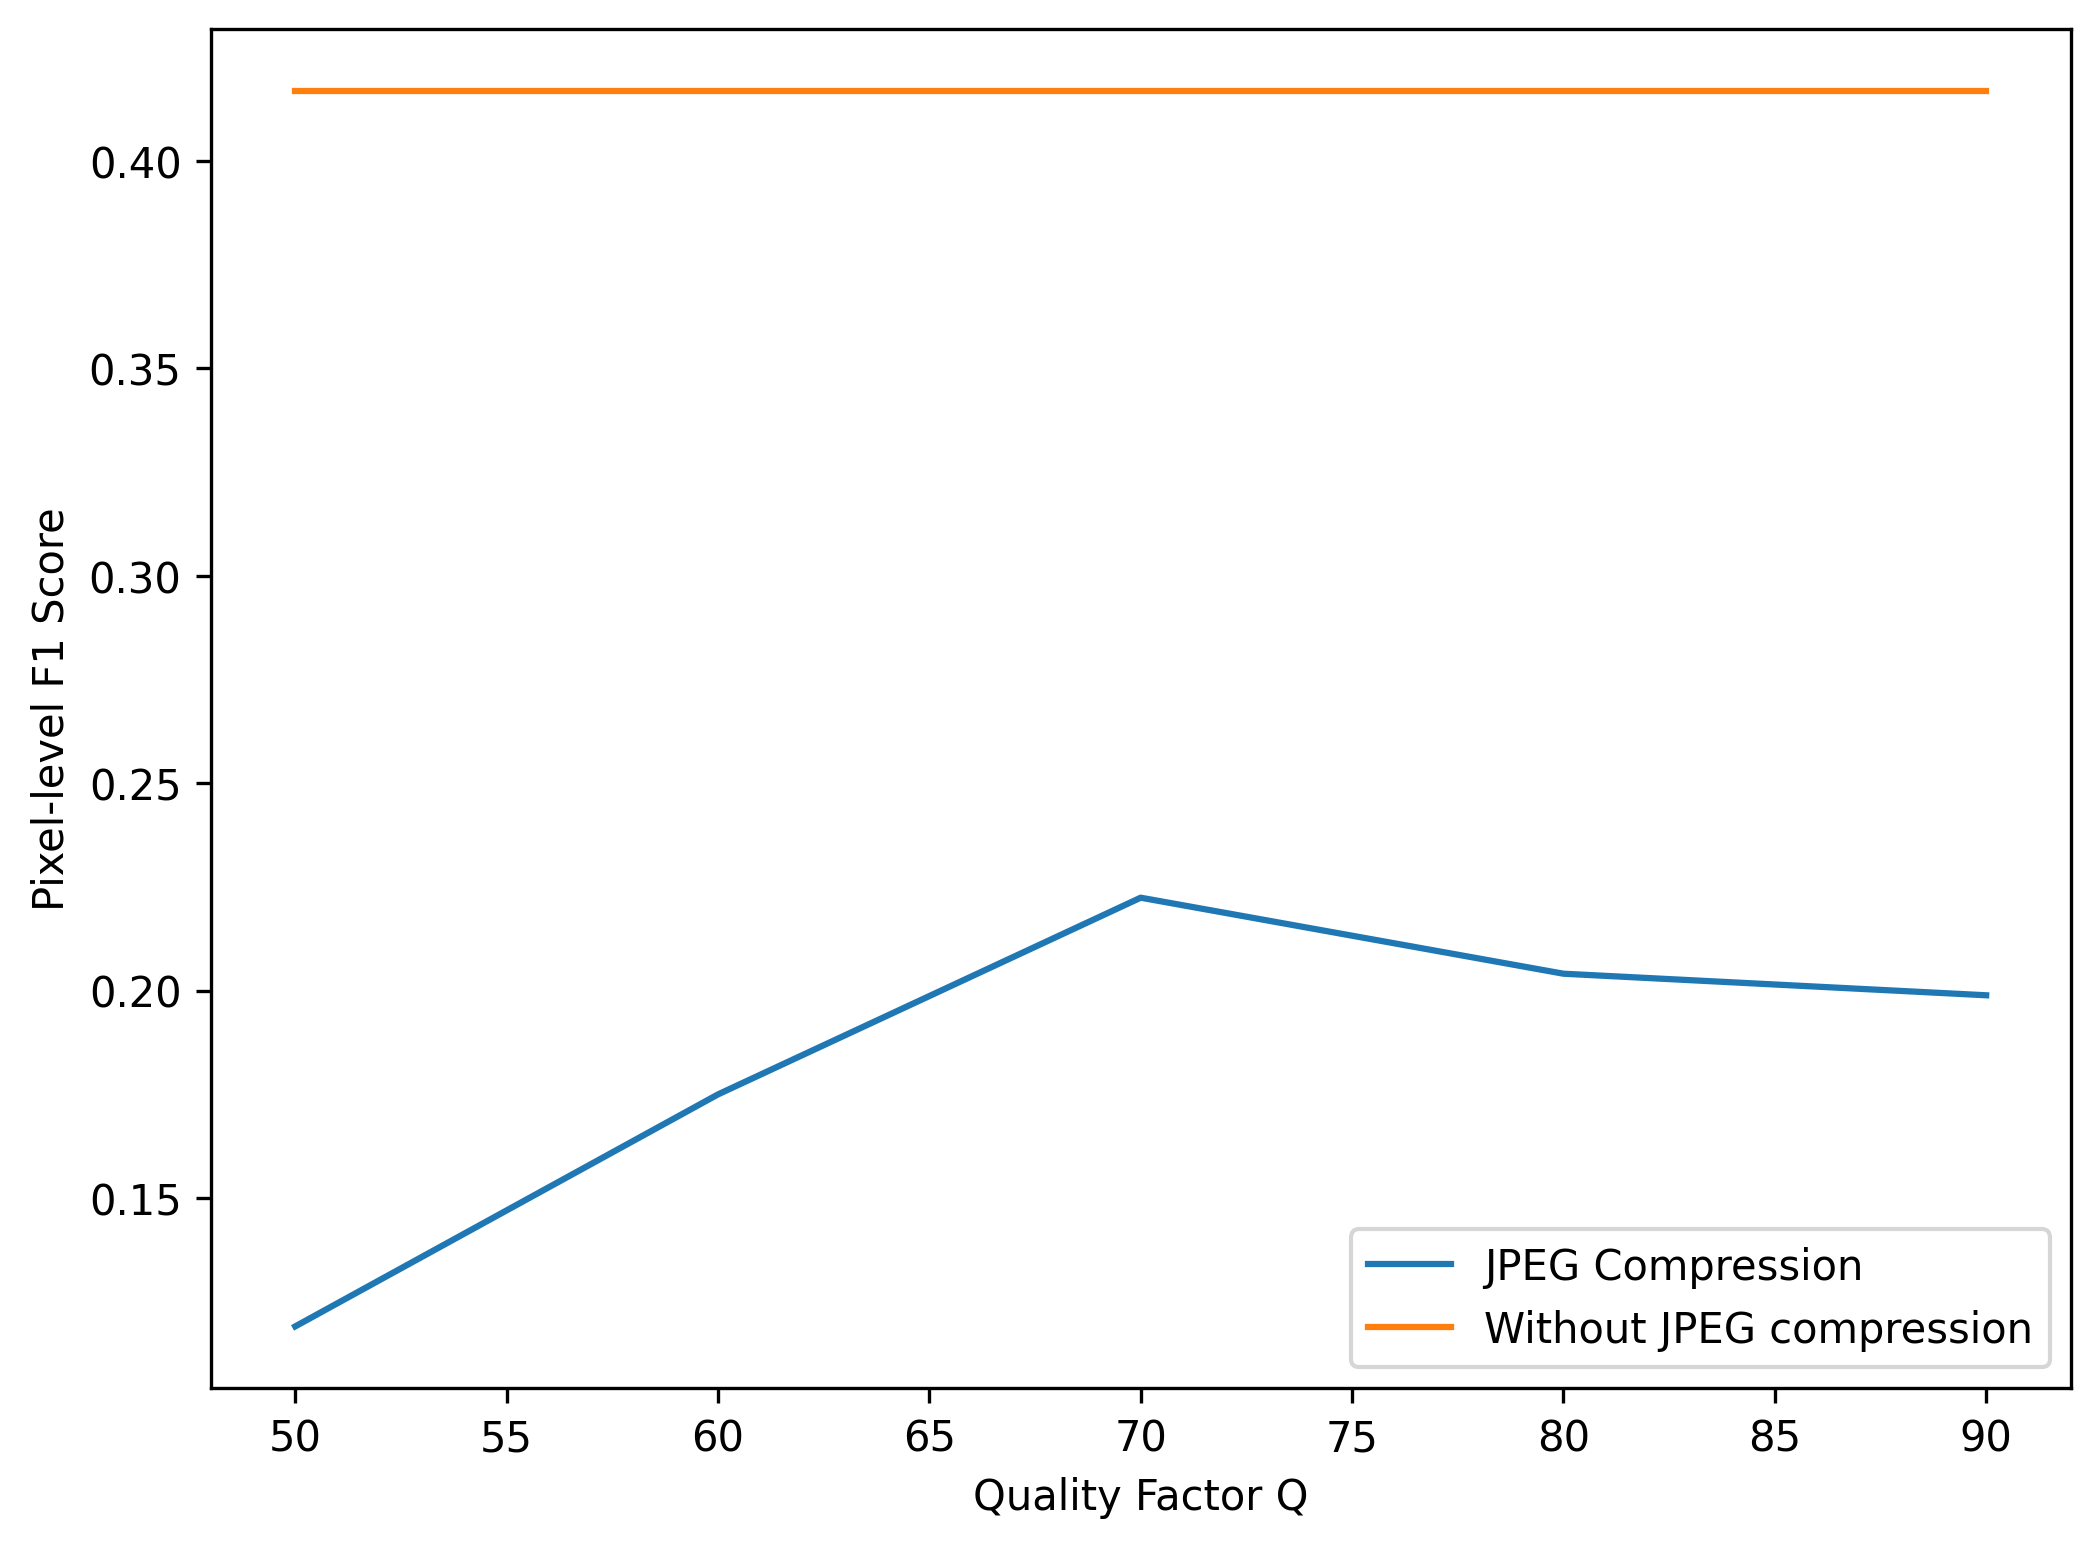

In [59]:
x = np.arange(50,100,10)
plt.xlabel("Quality Factor Q")
plt.ylabel("Pixel-level F1 Score")
plt.plot(x, y, label="JPEG Compression")
plt.plot(x, np.ones(5) * mean_f1['original'], label="Without JPEG compression")
plt.legend()
plt.show()

### Determine optimal threshold

In [33]:
th = np.arange(0.1, 0.3, 0.01)

res = np.zeros(th.shape)

for i, row in casia_data_paths.iterrows():
    stime = time.time()
    gt_path = os.path.join(ground_truth_dir, row['ground_truth'])
    gt_mask = (np.array(Image.open(gt_path).convert('L')) > 0).astype(int)

    for j, thres in enumerate(th):
        probs = results["original"][i]
        pred = (probs > thres).astype(int)
        f1 = pixel_f1_score(pred.reshape(-1), gt_mask.reshape(-1))
        res[j] += f1
    etime = time.time()
    print(f"Iter {i+1}/{644}: {round(etime - stime, 2)}s taken")

res /= 644

Iter 1/644: 1.45s taken
Iter 2/644: 1.41s taken
Iter 3/644: 1.61s taken
Iter 4/644: 1.31s taken
Iter 5/644: 1.06s taken
Iter 6/644: 0.99s taken
Iter 7/644: 0.41s taken
Iter 8/644: 0.36s taken
Iter 9/644: 1.46s taken
Iter 10/644: 1.28s taken
Iter 11/644: 1.33s taken
Iter 12/644: 1.39s taken
Iter 13/644: 1.44s taken
Iter 14/644: 1.54s taken
Iter 15/644: 0.67s taken
Iter 16/644: 0.6s taken
Iter 17/644: 0.67s taken
Iter 18/644: 1.92s taken
Iter 19/644: 1.72s taken
Iter 20/644: 1.29s taken
Iter 21/644: 0.45s taken
Iter 22/644: 1.29s taken
Iter 23/644: 1.0s taken
Iter 24/644: 1.01s taken
Iter 25/644: 0.54s taken
Iter 26/644: 0.68s taken
Iter 27/644: 1.14s taken
Iter 28/644: 1.02s taken
Iter 29/644: 0.92s taken
Iter 30/644: 1.36s taken
Iter 31/644: 1.11s taken
Iter 32/644: 0.87s taken
Iter 33/644: 1.09s taken
Iter 34/644: 1.02s taken
Iter 35/644: 1.03s taken
Iter 36/644: 1.03s taken
Iter 37/644: 0.91s taken
Iter 38/644: 0.82s taken
Iter 39/644: 1.09s taken
Iter 40/644: 1.11s taken
Iter 41/644

Iter 322/644: 0.99s taken
Iter 323/644: 2.66s taken
Iter 324/644: 0.96s taken
Iter 325/644: 0.84s taken
Iter 326/644: 1.47s taken
Iter 327/644: 0.77s taken
Iter 328/644: 0.96s taken
Iter 329/644: 1.07s taken
Iter 330/644: 1.27s taken
Iter 331/644: 1.23s taken
Iter 332/644: 1.08s taken
Iter 333/644: 1.07s taken
Iter 334/644: 1.25s taken
Iter 335/644: 1.14s taken
Iter 336/644: 3.41s taken
Iter 337/644: 1.23s taken
Iter 338/644: 0.8s taken
Iter 339/644: 2.67s taken
Iter 340/644: 1.05s taken
Iter 341/644: 1.05s taken
Iter 342/644: 0.47s taken
Iter 343/644: 0.66s taken
Iter 344/644: 0.81s taken
Iter 345/644: 0.74s taken
Iter 346/644: 0.57s taken
Iter 347/644: 0.93s taken
Iter 348/644: 1.15s taken
Iter 349/644: 0.74s taken
Iter 350/644: 1.1s taken
Iter 351/644: 0.51s taken
Iter 352/644: 0.88s taken
Iter 353/644: 0.72s taken
Iter 354/644: 0.93s taken
Iter 355/644: 0.83s taken
Iter 356/644: 1.08s taken
Iter 357/644: 0.4s taken
Iter 358/644: 1.06s taken
Iter 359/644: 2.68s taken
Iter 360/644: 1

Iter 639/644: 0.91s taken
Iter 640/644: 0.93s taken
Iter 641/644: 0.37s taken
Iter 642/644: 0.89s taken
Iter 643/644: 0.41s taken
Iter 644/644: 0.94s taken


In [39]:
for t, f1 in list(zip(th, res)):
    print(f"{t}: {round(f1, 3)}")

0.1: 0.383
0.11: 0.39
0.12: 0.396
0.13: 0.402
0.13999999999999999: 0.406
0.14999999999999997: 0.409
0.15999999999999998: 0.412
0.16999999999999998: 0.414
0.17999999999999997: 0.415
0.18999999999999995: 0.416
0.19999999999999996: 0.417
0.20999999999999996: 0.417
0.21999999999999995: 0.416
0.22999999999999995: 0.416
0.23999999999999994: 0.415
0.24999999999999992: 0.413
0.2599999999999999: 0.411
0.2699999999999999: 0.409
0.2799999999999999: 0.407
0.2899999999999999: 0.405


In [27]:
mean_f1

{'original': array([0.38259464, 0.41697641, 0.4024744 , 0.37148805, 0.33361447,
        0.29162196, 0.24503715, 0.19033707, 0.11960377]),
 '90': array([0.22499806, 0.20258309, 0.16161498, 0.12190032, 0.08917891,
        0.06264353, 0.0414373 , 0.0244388 , 0.01074675]),
 '80': array([0.23965669, 0.20861793, 0.16277655, 0.12130641, 0.0876982 ,
        0.06170556, 0.04112666, 0.02427903, 0.01054095]),
 '70': array([0.24766086, 0.22669412, 0.17835495, 0.13275492, 0.09480097,
        0.06488649, 0.04145996, 0.0228765 , 0.00795373]),
 '60': array([0.22475722, 0.18043496, 0.12986849, 0.0916346 , 0.06297996,
        0.0418107 , 0.02631153, 0.01447944, 0.00518297]),
 '50': array([0.18003511, 0.12453662, 0.07657293, 0.0447756 , 0.02475373,
        0.01285127, 0.0057992 , 0.00229113, 0.00057003])}

## Visualize results

In [12]:
threshold = 0.21

In [69]:
matplotlib.rcParams['figure.dpi'] = 100

In [13]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

In [15]:
for i, row in casia_data_paths.iterrows():
    tp_path = os.path.join(tampered_dir, row['tampered'])
    gt_path = os.path.join(ground_truth_dir, row['ground_truth'])
    
    tp_img = np.array(Image.open(tp_path))
    gt_mask = (np.array(Image.open(gt_path).convert('L')) > 0).astype(int)

    # original clean predictions by mantra net
    probs = predict(model, tp_img)
       
    # calculate f1 score based on baseline threshold of 0.5
    pred = (probs > threshold).astype(int)
    f1_original = pixel_f1_score(pred.reshape(-1), gt_mask.reshape(-1))

    nrow, ncol = len(compression_quality) + 2, 2
    plt.figure(figsize=(7*ncol,5*nrow))
    plt.subplot(nrow,ncol,1)
    plt.title('Ground truth')
    plt.imshow(gt_mask, cmap='gray')
    plt.subplot(nrow,ncol,2)
    plt.title('Ground truth')
    plt.imshow(gt_mask, cmap='gray')

    
    # original tampered image for reference
    plt.subplot(nrow,ncol,3)
    plt.title(f'No compression [{i+1}/{len(casia_data_paths)}]')
    plt.imshow(tp_img)        
    plt.subplot(nrow,ncol,4)
    plt.title(f'Prediction, pixel-level F1: {round(f1_original, 2)}')
    plt.imshow(pred, cmap='gray')
    
    # Compress images and show MantraNet predictions
    for j, q in enumerate(compression_quality):
        buffer = io.BytesIO()
        Image.open(tp_path).save(buffer, format='jpeg', quality=q, subsampling=0)
        compressed = np.array(Image.open(buffer))
        
        probs_compressed = predict(model, compressed)

        pred_compressed = (probs_compressed > threshold).astype(int)
        f1_compressed = pixel_f1_score(pred_compressed.reshape(-1), gt_mask.reshape(-1))
        
        # compressed images
        plt.subplot(nrow,ncol,ncol*(j+2)+1)
        plt.title(f'Quality Factor = {q}')
        plt.imshow(compressed)        
        plt.subplot(nrow,ncol,ncol*(j+2)+2)
        plt.title(f'Prediction, pixel-level F1: {round(f1_compressed, 2)}')
        plt.imshow(pred_compressed, cmap='gray')
        
    plt.savefig(f"jpeg_attack_{i+1}.png")
    if i == 50:
        break